In [1]:
ASSET = "SOLUSDT"
TARGET = "MA_7"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,179.06,634599.39,Extreme Fear,0.051981,0.040752,46.954810,18.002996,-3.72,9.27,9.19,-0.08,0.517269,0.001626,-0.473868,180.428571,182.025000
2022-01-02,176.35,620087.38,Fear,-0.015250,0.040740,45.504719,17.743547,-3.58,5.22,0.47,-4.75,0.504927,0.001610,-0.705077,177.362857,181.769286
2022-01-03,170.15,1031316.43,Fear,-0.035790,0.040847,42.287130,18.082047,-3.75,9.90,0.15,-9.75,0.520939,0.001411,-1.296484,173.717143,181.501429
2022-01-04,167.72,1041332.63,Extreme Fear,-0.014384,0.039753,41.061641,18.405135,-11.91,7.46,3.79,-3.67,0.487316,0.001499,-1.751934,172.345714,180.650714
2022-01-05,154.52,1659848.17,Extreme Fear,-0.081972,0.044788,35.109438,20.001075,-23.88,26.40,3.58,-22.82,0.468254,0.001723,-2.572725,170.044286,178.945000


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:53,956] A new study created in memory with name: no-name-74cc2551-813d-4922-bf3d-ad45388fe983
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0827 - val_loss: 0.2669
Epoch 2/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0757 - val_loss: 0.2039
Epoch 3/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0528 - val_loss: 0.1770
Epoch 4/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0426 - val_loss: 0.1513
Epoch 5/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0367 - val_loss: 0.1288
Epoch 6/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0365 - val_loss: 0.1103
Epoch 7/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0311 - val_loss: 0.0947
Epoch 8/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0252 - val_loss: 0.0750
Epoch 9/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0225 - val_loss: 0.0658
Epoch 10/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0155 - val_loss: 0.0528
Epoch 11/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0148 - val_loss: 0.0409
Epoch 12/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

[I 2025-05-09 19:34:16,736] Trial 0 finished with value: 647.0268531098244 and parameters: {'units_l0': 93, 'dropout_l0': 0.3326085399189944, 'learning_rate': 2.1208443999543346e-05, 'batch_size': 32, 'max_epochs': 53, 'sequence_length': 44}. Best is trial 0 with value: 647.0268531098244.


Epoch 1/73


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0839 - val_loss: 0.4104
Epoch 2/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0622 - val_loss: 0.3654
Epoch 3/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0598 - val_loss: 0.3249
Epoch 4/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0516 - val_loss: 0.2901
Epoch 5/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0427 - val_loss: 0.2624
Epoch 6/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0408 - val_loss: 0.2397
Epoch 7/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0409 - val_loss: 0.2188
Epoch 8/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0348 - val_loss: 0.2011
Epoch 9/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0322 - val_loss: 0.1865
Epoch 10/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0295 - val_loss: 0.1736
Epoch 11/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0276 - val_loss: 0.1638
Epoch 12/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0248 - val_l

[I 2025-05-09 19:34:57,923] Trial 1 finished with value: 754.1266348517825 and parameters: {'units_l0': 110, 'dropout_l0': 0.165110051164939, 'learning_rate': 1.015383697796825e-05, 'batch_size': 64, 'max_epochs': 73, 'sequence_length': 34}. Best is trial 0 with value: 647.0268531098244.


Epoch 1/29


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0548 - val_loss: 0.1198
Epoch 2/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - val_loss: 0.0501
Epoch 3/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097 - val_loss: 0.0270
Epoch 4/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0278
Epoch 5/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.0219
Epoch 6/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056 - val_loss: 0.0172
Epoch 7/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - val_loss: 0.0258
Epoch 8/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - val_loss: 0.0233
Epoch 9/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0204
Epoch 10/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - val_loss: 0.0194
Epoch 11/29
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - val_loss: 0.0223
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-05-09 19:35:07,510] Trial 2 finished with value: 967.9078252235726 and parameters: {'units_l0': 100, 'dropout_l0': 0.2849323007776289, 'learning_rate': 7.427705162386468e-05, 'batch_size': 16, 'max_epochs': 29, 'sequence_length': 13}. Best is trial 0 with value: 647.0268531098244.


Epoch 1/93


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0875 - val_loss: 0.0123
Epoch 2/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0118 - val_loss: 0.0442
Epoch 3/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0118 - val_loss: 0.0403
Epoch 4/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107 - val_loss: 0.0337
Epoch 5/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0108 - val_loss: 0.0470
Epoch 6/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0086 - val_loss: 0.0335
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-05-09 19:35:15,747] Trial 3 finished with value: 694.6898794233376 and parameters: {'units_l0': 82, 'dropout_l0': 0.4718390070230869, 'learning_rate': 0.004646494380448755, 'batch_size': 32, 'max_epochs': 93, 'sequence_length': 19}. Best is trial 0 with value: 647.0268531098244.


Epoch 1/85


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0308 - val_loss: 0.0309
Epoch 2/85
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0053 - val_loss: 0.0157
Epoch 3/85
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0050 - val_loss: 0.0287
Epoch 4/85
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038 - val_loss: 0.0328
Epoch 5/85
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0043 - val_loss: 0.0237
Epoch 6/85
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_loss: 0.0447
Epoch 7/85
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0033 - val_loss: 0.0283
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-05-09 19:35:28,046] Trial 4 finished with value: 883.4401529219317 and parameters: {'units_l0': 182, 'dropout_l0': 0.23938976792274175, 'learning_rate': 0.0006017487858668569, 'batch_size': 16, 'max_epochs': 85, 'sequence_length': 22}. Best is trial 0 with value: 647.0268531098244.


Epoch 1/76


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.0779 - val_loss: 0.0581
Epoch 2/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0067 - val_loss: 0.0113
Epoch 3/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0038 - val_loss: 0.0153
Epoch 4/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0025 - val_loss: 0.0069
Epoch 5/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0035 - val_loss: 0.0162
Epoch 6/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0030 - val_loss: 0.0168
Epoch 7/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0026 - val_loss: 0.0164
Epoch 8/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0020 - val_loss: 0.0169
Epoch 9/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025 - val_loss: 0.0184
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-05-09 19:35:42,314] Trial 5 finished with value: 389.3056405836823 and parameters: {'units_l0': 145, 'dropout_l0': 0.12817703308040668, 'learning_rate': 0.0025249051786205468, 'batch_size': 64, 'max_epochs': 76, 'sequence_length': 32}. Best is trial 5 with value: 389.3056405836823.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.3948 - val_loss: 0.0428
Epoch 2/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0082 - val_loss: 0.0265
Epoch 3/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0064 - val_loss: 0.0407
Epoch 4/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0059 - val_loss: 0.0241
Epoch 5/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0060 - val_loss: 0.0295
Epoch 6/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0082 - val_loss: 0.0417
Epoch 7/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045 - val_loss: 0.0366
Epoch 8/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0056 - val_loss: 0.0542
Epoch 9/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046 - val_loss: 0.0584
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-05-09 19:35:57,856] Trial 6 finished with value: 1356.5011264747898 and parameters: {'units_l0': 180, 'dropout_l0': 0.3584641606951236, 'learning_rate': 0.006631139595161788, 'batch_size': 16, 'max_epochs': 66, 'sequence_length': 30}. Best is trial 5 with value: 389.3056405836823.


Epoch 1/37


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.1508 - val_loss: 0.2485
Epoch 2/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0336 - val_loss: 0.1370
Epoch 3/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0161 - val_loss: 0.0872
Epoch 4/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0067 - val_loss: 0.0535
Epoch 5/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0044 - val_loss: 0.0374
Epoch 6/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042 - val_loss: 0.0319
Epoch 7/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0287
Epoch 8/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 0.0247
Epoch 9/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 0.0221
Epoch 10/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0247
Epoch 11/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 0.0222
Epoch 12/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023 - val_l

[I 2025-05-09 19:36:30,501] Trial 7 finished with value: 823.8553404974505 and parameters: {'units_l0': 56, 'dropout_l0': 0.04984018843694926, 'learning_rate': 6.813715111808704e-05, 'batch_size': 16, 'max_epochs': 37, 'sequence_length': 47}. Best is trial 5 with value: 389.3056405836823.


Epoch 1/49


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.1156 - val_loss: 0.4008
Epoch 2/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0707 - val_loss: 0.2726
Epoch 3/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0506 - val_loss: 0.2054
Epoch 4/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0443 - val_loss: 0.1633
Epoch 5/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0351 - val_loss: 0.1301
Epoch 6/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0274 - val_loss: 0.1049
Epoch 7/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0233 - val_loss: 0.0798
Epoch 8/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0165 - val_loss: 0.0642
Epoch 9/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0132 - val_loss: 0.0472
Epoch 10/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0112 - val_loss: 0.0383
Epoch 11/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0086 - val_loss: 0.0298
Epoch 12/49
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0074 - val_l

[I 2025-05-09 19:37:15,627] Trial 8 finished with value: 961.0816413211 and parameters: {'units_l0': 128, 'dropout_l0': 0.13079987095487833, 'learning_rate': 1.0597581294250638e-05, 'batch_size': 16, 'max_epochs': 49, 'sequence_length': 50}. Best is trial 5 with value: 389.3056405836823.


Epoch 1/19


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0235 - val_loss: 0.0241
Epoch 2/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0126 - val_loss: 0.0219
Epoch 3/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0086 - val_loss: 0.0296
Epoch 4/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0083 - val_loss: 0.0232
Epoch 5/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0081 - val_loss: 0.0372
Epoch 6/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0068 - val_loss: 0.0531
Epoch 7/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0066 - val_loss: 0.0248
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


[I 2025-05-09 19:37:32,517] Trial 9 finished with value: 1236.9735263360612 and parameters: {'units_l0': 196, 'dropout_l0': 0.4327189898575115, 'learning_rate': 0.00048014622707081867, 'batch_size': 32, 'max_epochs': 19, 'sequence_length': 46}. Best is trial 5 with value: 389.3056405836823.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0699 - val_loss: 0.0375
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0022 - val_loss: 0.0053
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0012 - val_loss: 0.0104
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011 - val_loss: 0.0090
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 9.3062e-04 - val_loss: 0.0082
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.1526e-04 - val_loss: 0.0072
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-05-09 19:37:43,829] Trial 10 finished with value: 290.9197096368294 and parameters: {'units_l0': 142, 'dropout_l0': 0.03354577995340852, 'learning_rate': 0.0017754345755663003, 'batch_size': 64, 'max_epochs': 100, 'sequence_length': 28}. Best is trial 10 with value: 290.9197096368294.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.1067 - val_loss: 0.0406
Epoch 2/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0061 - val_loss: 0.0129
Epoch 3/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 4/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0011 - val_loss: 0.0103
Epoch 5/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.8940e-04 - val_loss: 0.0098
Epoch 6/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.7959e-04 - val_loss: 0.0113
Epoch 7/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 8.2830e-04 - val_loss: 0.0094
Epoch 8/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.2084e-04 - val_loss: 0.0081
Epoch 9/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.7275e-04 - val_loss: 0.0076
Epoch 10/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.3384e-04 - val_loss: 0.0061
Epoch 11/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.6074e-04 - val_loss: 0.0068
Epoch 12/96
14/14 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:38:14,437] Trial 11 finished with value: 172.71779543998363 and parameters: {'units_l0': 147, 'dropout_l0': 0.013730929160592403, 'learning_rate': 0.002606574757213154, 'batch_size': 64, 'max_epochs': 96, 'sequence_length': 59}. Best is trial 11 with value: 172.71779543998363.


Epoch 1/97


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0642 - val_loss: 0.0082
Epoch 2/97
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 3/97
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/97
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.8548e-04 - val_loss: 0.0043
Epoch 5/97
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.6072e-04 - val_loss: 0.0040
Epoch 6/97
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 3.1635e-04 - val_loss: 0.0038
Epoch 7/97
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.0603e-04 - val_loss: 0.0036
Epoch 8/97
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.3231e-04 - val_loss: 0.0031
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-05-09 19:38:29,402] Trial 12 finished with value: 113.84326629433433 and parameters: {'units_l0': 148, 'dropout_l0': 0.008145498396673022, 'learning_rate': 0.0016001799461356758, 'batch_size': 64, 'max_epochs': 97, 'sequence_length': 56}. Best is trial 12 with value: 113.84326629433433.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0586 - val_loss: 0.0192
Epoch 2/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 3/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.5277e-04 - val_loss: 0.0046
Epoch 4/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4.6677e-04 - val_loss: 0.0022
Epoch 5/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.6255e-04 - val_loss: 0.0052
Epoch 6/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.5865e-04 - val_loss: 0.0028
Epoch 7/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.1805e-04 - val_loss: 0.0028
Epoch 8/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.3323e-04 - val_loss: 0.0030
Epoch 9/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1750e-04 - val_loss: 0.0015
Epoch 10/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.2989e-04 - val_loss: 0.0043
Epoch 11/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6068e-04 - val_loss: 7.6284e-04
Epoch 12/88
14/14 ━━━━

[I 2025-05-09 19:38:50,722] Trial 13 finished with value: 43.01148654329467 and parameters: {'units_l0': 159, 'dropout_l0': 0.0006127773818757846, 'learning_rate': 0.0015426425867842686, 'batch_size': 64, 'max_epochs': 88, 'sequence_length': 59}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0473 - val_loss: 0.0015
Epoch 2/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 3/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0025 - val_loss: 0.0122
Epoch 4/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 5/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0017 - val_loss: 0.0106
Epoch 6/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0014 - val_loss: 0.0082
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-05-09 19:39:02,808] Trial 14 finished with value: 81.77582190919101 and parameters: {'units_l0': 164, 'dropout_l0': 0.08740310088794118, 'learning_rate': 0.0009259742196151912, 'batch_size': 64, 'max_epochs': 84, 'sequence_length': 59}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0511 - val_loss: 0.0268
Epoch 2/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0105 - val_loss: 0.0314
Epoch 3/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0033 - val_loss: 0.0092
Epoch 4/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0031 - val_loss: 0.0114
Epoch 5/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0028 - val_loss: 0.0124
Epoch 6/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 7/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 8/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 9/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0020 - val_loss: 0.0120
Epoch 10/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0020 - val_loss: 0.0083
Epoch 11/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 12/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0

[I 2025-05-09 19:39:22,432] Trial 15 finished with value: 370.98890201259786 and parameters: {'units_l0': 170, 'dropout_l0': 0.09329229810159573, 'learning_rate': 0.00017659608493841538, 'batch_size': 64, 'max_epochs': 82, 'sequence_length': 53}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/63


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0449 - val_loss: 0.0084
Epoch 2/63
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0062 - val_loss: 0.0135
Epoch 3/63
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0041 - val_loss: 0.0136
Epoch 4/63
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0035 - val_loss: 0.0129
Epoch 5/63
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0043 - val_loss: 0.0165
Epoch 6/63
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0033 - val_loss: 0.0151
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-05-09 19:39:33,433] Trial 16 finished with value: 475.8371476779395 and parameters: {'units_l0': 164, 'dropout_l0': 0.19230649761593874, 'learning_rate': 0.0009636881465723261, 'batch_size': 64, 'max_epochs': 63, 'sequence_length': 40}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/86


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0488 - val_loss: 0.0348
Epoch 2/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0111 - val_loss: 0.0214
Epoch 3/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0053 - val_loss: 0.0080
Epoch 4/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 5/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 6/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 7/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 8/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 9/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0022 - val_loss: 0.0076
Epoch 10/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0016 - val_loss: 0.0102
Epoch 11/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 12/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0022 - val_l

[I 2025-05-09 19:39:49,586] Trial 17 finished with value: 210.20084056767536 and parameters: {'units_l0': 125, 'dropout_l0': 0.07774198580081954, 'learning_rate': 0.00023288730129834267, 'batch_size': 64, 'max_epochs': 86, 'sequence_length': 57}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 1.1400 - val_loss: 0.0474
Epoch 2/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0109 - val_loss: 0.0341
Epoch 3/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0063 - val_loss: 0.0255
Epoch 4/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0051 - val_loss: 0.0208
Epoch 5/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0046 - val_loss: 0.0180
Epoch 6/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0044 - val_loss: 0.0174
Epoch 7/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0050 - val_loss: 0.0166
Epoch 8/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0039 - val_loss: 0.0147
Epoch 9/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0041 - val_loss: 0.0204
Epoch 10/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0040 - val_loss: 0.0170
Epoch 11/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0034 - val_loss: 0.0216
Epoch 12/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.

[I 2025-05-09 19:40:08,757] Trial 18 finished with value: 828.1754181785024 and parameters: {'units_l0': 196, 'dropout_l0': 0.20862207801061505, 'learning_rate': 0.007867530817125963, 'batch_size': 64, 'max_epochs': 65, 'sequence_length': 39}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0284 - val_loss: 0.0072
Epoch 2/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 3/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0031 - val_loss: 0.0097
Epoch 4/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0031 - val_loss: 0.0089
Epoch 5/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0017 - val_loss: 0.0074
Epoch 6/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0021 - val_loss: 0.0098
Epoch 7/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0019 - val_loss: 0.0092
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-05-09 19:40:21,670] Trial 19 finished with value: 204.31639510482503 and parameters: {'units_l0': 165, 'dropout_l0': 0.09881332923811442, 'learning_rate': 0.0009404508410053437, 'batch_size': 64, 'max_epochs': 43, 'sequence_length': 60}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/76


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0477 - val_loss: 0.0959
Epoch 2/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0125 - val_loss: 0.0352
Epoch 3/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0065 - val_loss: 0.0168
Epoch 4/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0048 - val_loss: 0.0162
Epoch 5/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0037 - val_loss: 0.0136
Epoch 6/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0043 - val_loss: 0.0184
Epoch 7/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0033 - val_loss: 0.0120
Epoch 8/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028 - val_loss: 0.0159
Epoch 9/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0049 - val_loss: 0.0150
Epoch 10/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0035 - val_loss: 0.0145
Epoch 11/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037 - val_loss: 0.0124
Epoch 12/76
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0033 - val_l

[I 2025-05-09 19:40:40,070] Trial 20 finished with value: 674.4680958097629 and parameters: {'units_l0': 121, 'dropout_l0': 0.14826165258175966, 'learning_rate': 0.0001080892610935374, 'batch_size': 32, 'max_epochs': 76, 'sequence_length': 53}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0560 - val_loss: 0.0109
Epoch 2/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 3/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 4/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 5/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.1169e-04 - val_loss: 0.0011
Epoch 6/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.7298e-04 - val_loss: 0.0034
Epoch 7/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.6105e-04 - val_loss: 0.0036
Epoch 8/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 7.6392e-04 - val_loss: 0.0046
Epoch 9/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.8291e-04 - val_loss: 0.0022
Epoch 10/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.7228e-04 - val_loss: 0.0039
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-05-09 19:40:55,253] Trial 21 finished with value: 64.818165781113 and parameters: {'units_l0': 153, 'dropout_l0': 0.02122917087448381, 'learning_rate': 0.0011098415889611876, 'batch_size': 64, 'max_epochs': 90, 'sequence_length': 55}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0243 - val_loss: 0.0088
Epoch 2/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0036 - val_loss: 0.0127
Epoch 3/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 4/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0019 - val_loss: 0.0128
Epoch 5/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0015 - val_loss: 0.0085
Epoch 6/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0019 - val_loss: 0.0127
Epoch 7/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0020 - val_loss: 0.0066
Epoch 8/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0020 - val_loss: 0.0093
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-05-09 19:41:11,117] Trial 22 finished with value: 333.03130527510575 and parameters: {'units_l0': 157, 'dropout_l0': 0.07033135519811584, 'learning_rate': 0.00044237757491286377, 'batch_size': 64, 'max_epochs': 89, 'sequence_length': 53}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0448 - val_loss: 0.0069
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0079 - val_loss: 0.0116
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0029 - val_loss: 0.0079
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0015 - val_loss: 0.0114
Epoch 6/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 7/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 8/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0012 - val_loss: 0.0082
Epoch 9/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 10/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 8.4965e-04 - val_loss: 0.0063
Epoch 12/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss

[I 2025-05-09 19:41:39,074] Trial 23 finished with value: 202.63635698400336 and parameters: {'units_l0': 180, 'dropout_l0': 0.03859526938351422, 'learning_rate': 0.0009849237350992093, 'batch_size': 64, 'max_epochs': 80, 'sequence_length': 60}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.1369 - val_loss: 0.0338
Epoch 2/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0054 - val_loss: 0.0084
Epoch 3/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 4/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 5/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.2579e-04 - val_loss: 0.0046
Epoch 6/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.1864e-04 - val_loss: 0.0047
Epoch 7/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.0573e-04 - val_loss: 0.0046
Epoch 8/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.3677e-04 - val_loss: 0.0036
Epoch 9/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.6225e-04 - val_loss: 0.0043
Epoch 10/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.3043e-04 - val_loss: 0.0057
Epoch 11/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.8066e-04 - val_loss: 0.0046
Epoch 12/71
14/14 ━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:41:54,959] Trial 24 finished with value: 201.26663323577995 and parameters: {'units_l0': 136, 'dropout_l0': 0.009659251983108762, 'learning_rate': 0.003919691987824176, 'batch_size': 64, 'max_epochs': 71, 'sequence_length': 49}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0515 - val_loss: 0.0238
Epoch 2/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0038 - val_loss: 0.0239
Epoch 3/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0012 - val_loss: 0.0109
Epoch 4/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.6020e-04 - val_loss: 0.0113
Epoch 5/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.1053e-04 - val_loss: 0.0093
Epoch 6/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.0215e-04 - val_loss: 0.0072
Epoch 7/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.8621e-04 - val_loss: 0.0072
Epoch 8/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.4520e-04 - val_loss: 0.0064
Epoch 9/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.6761e-04 - val_loss: 0.0066
Epoch 10/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2580e-04 - val_loss: 0.0048
Epoch 11/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.3980e-04 - val_loss: 0.0048
Epoch 12/89
14/14 ━━━━━━━━━━━━━

[I 2025-05-09 19:42:27,471] Trial 25 finished with value: 109.66215953545857 and parameters: {'units_l0': 160, 'dropout_l0': 0.001738919391025412, 'learning_rate': 0.0014364056285210765, 'batch_size': 64, 'max_epochs': 89, 'sequence_length': 42}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0473 - val_loss: 0.0706
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0108 - val_loss: 0.0158
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0041 - val_loss: 0.0102
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0035 - val_loss: 0.0080
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0031 - val_loss: 0.0101
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0024 - val_loss: 0.0121
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0016 - val_loss: 0.0127
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0019 - val_loss: 0.0094
Epoch 9/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0024 - val_loss: 0.0127
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2025-05-09 19:42:42,751] Trial 26 finished with value: 452.65309973062784 and parameters: {'units_l0': 154, 'dropout_l0': 0.10667152669875682, 'learning_rate': 0.0003276281433049345, 'batch_size': 64, 'max_epochs': 60, 'sequence_length': 55}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0323 - val_loss: 0.0060
Epoch 2/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0051 - val_loss: 0.0075
Epoch 3/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0026 - val_loss: 0.0087
Epoch 4/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 5/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 6/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0015 - val_loss: 0.0096
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-05-09 19:42:54,165] Trial 27 finished with value: 335.4956214461689 and parameters: {'units_l0': 173, 'dropout_l0': 0.06695038146300891, 'learning_rate': 0.0007281801438380037, 'batch_size': 64, 'max_epochs': 91, 'sequence_length': 51}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/100


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 0.1398 - val_loss: 0.0231
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0054 - val_loss: 0.0072
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0040 - val_loss: 0.0139
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0019 - val_loss: 0.0140
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0017 - val_loss: 0.0117
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0021 - val_loss: 0.0149
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0015 - val_loss: 0.0131
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-05-09 19:43:09,262] Trial 28 finished with value: 403.2749972223447 and parameters: {'units_l0': 189, 'dropout_l0': 0.062469763585162555, 'learning_rate': 0.0026201642256184396, 'batch_size': 64, 'max_epochs': 100, 'sequence_length': 55}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.1054 - val_loss: 0.0142
Epoch 2/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0093 - val_loss: 0.0210
Epoch 3/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0054 - val_loss: 0.0155
Epoch 4/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0058 - val_loss: 0.0333
Epoch 5/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054 - val_loss: 0.0259
Epoch 6/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0045 - val_loss: 0.0263
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


[I 2025-05-09 19:43:20,635] Trial 29 finished with value: 799.1415184431156 and parameters: {'units_l0': 132, 'dropout_l0': 0.3220181832018055, 'learning_rate': 0.004320423359882528, 'batch_size': 32, 'max_epochs': 53, 'sequence_length': 44}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0842 - val_loss: 0.1329
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0141 - val_loss: 0.0364
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0076 - val_loss: 0.0171
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0039 - val_loss: 0.0183
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0043 - val_loss: 0.0217
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0036 - val_loss: 0.0201
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0032 - val_loss: 0.0138
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0033 - val_loss: 0.0171
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0038 - val_loss: 0.0141
Epoch 10/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0034 - val_loss: 0.0206
Epoch 11/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0033 - val_loss: 0.0165
Epoch 12/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0

[I 2025-05-09 19:43:39,784] Trial 30 finished with value: 775.41880034817 and parameters: {'units_l0': 113, 'dropout_l0': 0.17381018626356598, 'learning_rate': 0.00018035957496658698, 'batch_size': 32, 'max_epochs': 80, 'sequence_length': 57}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0666 - val_loss: 0.0070
Epoch 2/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0021 - val_loss: 0.0112
Epoch 3/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 4/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.5248e-04 - val_loss: 0.0028
Epoch 5/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.1343e-04 - val_loss: 0.0029
Epoch 6/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.4187e-04 - val_loss: 0.0022
Epoch 7/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.9010e-04 - val_loss: 0.0031
Epoch 8/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.4944e-04 - val_loss: 0.0021
Epoch 9/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.3026e-04 - val_loss: 0.0029
Epoch 10/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 1.9243e-04 - val_loss: 0.0016
Epoch 11/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.4999e-04 - val_loss: 0.0026
Epoch 12/90
14/14 ━━━━━━━━━━━━

[I 2025-05-09 19:43:59,110] Trial 31 finished with value: 90.4904053152114 and parameters: {'units_l0': 159, 'dropout_l0': 0.0024175337835011385, 'learning_rate': 0.0014835744450673177, 'batch_size': 64, 'max_epochs': 90, 'sequence_length': 39}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/72


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0409 - val_loss: 0.0108
Epoch 2/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 3/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 4/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.8488e-04 - val_loss: 0.0023
Epoch 5/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 6/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 7/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.8222e-04 - val_loss: 0.0047
Epoch 8/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 8.3895e-04 - val_loss: 0.0034
Epoch 9/72
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.5922e-04 - val_loss: 0.0060
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-05-09 19:44:10,038] Trial 32 finished with value: 130.11821669796078 and parameters: {'units_l0': 154, 'dropout_l0': 0.0364225198260209, 'learning_rate': 0.0013603996285948081, 'batch_size': 64, 'max_epochs': 72, 'sequence_length': 36}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/92


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0955 - val_loss: 0.0221
Epoch 2/92
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 3/92
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 4/92
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.9471e-04 - val_loss: 0.0042
Epoch 5/92
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.4987e-04 - val_loss: 0.0048
Epoch 6/92
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.4901e-04 - val_loss: 0.0036
Epoch 7/92
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.7002e-04 - val_loss: 0.0040
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-05-09 19:44:19,041] Trial 33 finished with value: 138.37883570743688 and parameters: {'units_l0': 172, 'dropout_l0': 0.0018285223712345884, 'learning_rate': 0.0020286209286876624, 'batch_size': 64, 'max_epochs': 92, 'sequence_length': 24}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/87
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0608 - val_loss: 0.0945
Epoch 2/87
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0089 - val_loss: 0.0046
Epoch 3/87
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0093
Epoch 4/87
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024 - val_loss: 0.0128
Epoch 5/87
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - val_loss: 0.0103
Epoch 6/87
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010 - val_loss: 0.0086
Epoch 7/87
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012 - val_loss: 0.0083
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-05-09 19:44:26,427] Trial 34 finished with value: 261.27235194023336 and parameters: {'units_l0': 83, 'dropout_l0': 0.036925227588720126, 'learning_rate': 0.0006863579646536621, 'batch_size': 64, 'max_epochs': 87, 'sequence_length': 13}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/82


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.1223 - val_loss: 0.0577
Epoch 2/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0086 - val_loss: 0.0049
Epoch 3/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0041 - val_loss: 0.0086
Epoch 4/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0033 - val_loss: 0.0101
Epoch 5/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0023 - val_loss: 0.0110
Epoch 6/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0031 - val_loss: 0.0118
Epoch 7/82
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0025 - val_loss: 0.0152
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


[I 2025-05-09 19:44:36,998] Trial 35 finished with value: 273.8448013310074 and parameters: {'units_l0': 136, 'dropout_l0': 0.11553134324422543, 'learning_rate': 0.0033889640279902724, 'batch_size': 64, 'max_epochs': 82, 'sequence_length': 48}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0294 - val_loss: 0.0257
Epoch 2/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0067 - val_loss: 0.0223
Epoch 3/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0057 - val_loss: 0.0233
Epoch 4/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0050 - val_loss: 0.0172
Epoch 5/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0048 - val_loss: 0.0405
Epoch 6/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051 - val_loss: 0.0313
Epoch 7/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0043 - val_loss: 0.0238
Epoch 8/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034 - val_loss: 0.0355
Epoch 9/95
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - val_loss: 0.0381
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-05-09 19:44:55,598] Trial 36 finished with value: 972.2338056460726 and parameters: {'units_l0': 186, 'dropout_l0': 0.2635693485569367, 'learning_rate': 0.0003845125914629837, 'batch_size': 16, 'max_epochs': 95, 'sequence_length': 35}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.1284 - val_loss: 0.1178
Epoch 2/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0115 - val_loss: 0.0381
Epoch 3/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0048 - val_loss: 0.0265
Epoch 4/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0036 - val_loss: 0.0325
Epoch 5/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0026 - val_loss: 0.0296
Epoch 6/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0024 - val_loss: 0.0194
Epoch 7/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019 - val_loss: 0.0221
Epoch 8/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022 - val_loss: 0.0163
Epoch 9/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019 - val_loss: 0.0222
Epoch 10/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0015 - val_loss: 0.0178
Epoch 11/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - val_loss: 0.0178
Epoch 12/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0

[I 2025-05-09 19:45:10,354] Trial 37 finished with value: 918.9501366353918 and parameters: {'units_l0': 115, 'dropout_l0': 0.07557114013813669, 'learning_rate': 0.001035308466200408, 'batch_size': 64, 'max_epochs': 12, 'sequence_length': 45}. Best is trial 13 with value: 43.01148654329467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0795 - val_loss: 0.1956
Epoch 2/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0511 - val_loss: 0.1258
Epoch 3/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0402 - val_loss: 0.1000
Epoch 4/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0282 - val_loss: 0.0841
Epoch 5/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0212 - val_loss: 0.0598
Epoch 6/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0163 - val_loss: 0.0461
Epoch 7/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0145 - val_loss: 0.0307
Epoch 8/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0102 - val_loss: 0.0256
Epoch 9/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0076 - val_loss: 0.0171
Epoch 10/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0069 - val_loss: 0.0140
Epoch 11/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0060 - val_loss: 0.0127
Epoch 12/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0

[I 2025-05-09 19:45:32,183] Trial 38 finished with value: 590.58687764261 and parameters: {'units_l0': 175, 'dropout_l0': 0.15650427177374246, 'learning_rate': 3.396688185507709e-05, 'batch_size': 64, 'max_epochs': 71, 'sequence_length': 52}. Best is trial 13 with value: 43.01148654329467.


Epoch 1/78


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0892 - val_loss: 0.0360
Epoch 2/78
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0150
Epoch 3/78
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0255
Epoch 4/78
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0459
Epoch 5/78
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0665
Epoch 6/78
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - val_loss: 0.0776
Epoch 7/78
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0679
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-09 19:45:39,378] Trial 39 finished with value: 846.0927072192997 and parameters: {'units_l0': 101, 'dropout_l0': 0.402243764433596, 'learning_rate': 0.006603478002654391, 'batch_size': 16, 'max_epochs': 78, 'sequence_length': 10}. Best is trial 13 with value: 43.01148654329467.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
13,159,0.000613,0.001543,64,88,59,43.011487
21,153,0.021229,0.001110,64,90,55,64.818166
14,164,0.087403,0.000926,64,84,59,81.775822
31,159,0.002418,0.001484,64,90,39,90.490405
25,160,0.001739,0.001436,64,89,42,109.662160
12,148,0.008145,0.001600,64,97,56,113.843266
32,154,0.036423,0.001360,64,72,36,130.118217
33,172,0.001829,0.002029,64,92,24,138.378836
11,147,0.013731,0.002607,64,96,59,172.717795
24,136,0.009659,0.003920,64,71,49,201.266633


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0787 - val_loss: 0.0224
Epoch 2/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0044 - val_loss: 0.0101
Epoch 3/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0018 - val_loss: 0.0086
Epoch 4/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 6.2523e-04 - val_loss: 0.0062
Epoch 5/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 3.4921e-04 - val_loss: 0.0059
Epoch 6/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.5823e-04 - val_loss: 0.0057
Epoch 7/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5561e-04 - val_loss: 0.0048
Epoch 8/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2888e-04 - val_loss: 0.0065
Epoch 9/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.4280e-04 - val_loss: 0.0046
Epoch 10/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.6659e-04 - val_loss: 0.0052
Epoch 11/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.2220e-04 - val_loss: 0.0043
Epoch 12/88
14/14 ━━━━━━━━━━━━━

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_pred, y_val_inv)
mse_naive = mean_squared_error(y_pred, naive_close)
mse_naive_target = mean_squared_error(y_pred, naive_target)

# Print MSE
print(f"MSE (Predicted - Tomorrow's Close): {mse:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Close): {mse_naive:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Shapes:
y_pred: (203,), y_val: (203,)
Naive benchmark shape: (203,)
MSE (Predicted - Tomorrow's Close): 29242.3354
MSE (Naive Model - Today's Target as Tomorrow's Target): 29193.2501
MSE (Naive Model - Today's Close as Tomorrow's Close): 29393.0467


In [8]:
df.to_csv("tmp_df_data.csv")

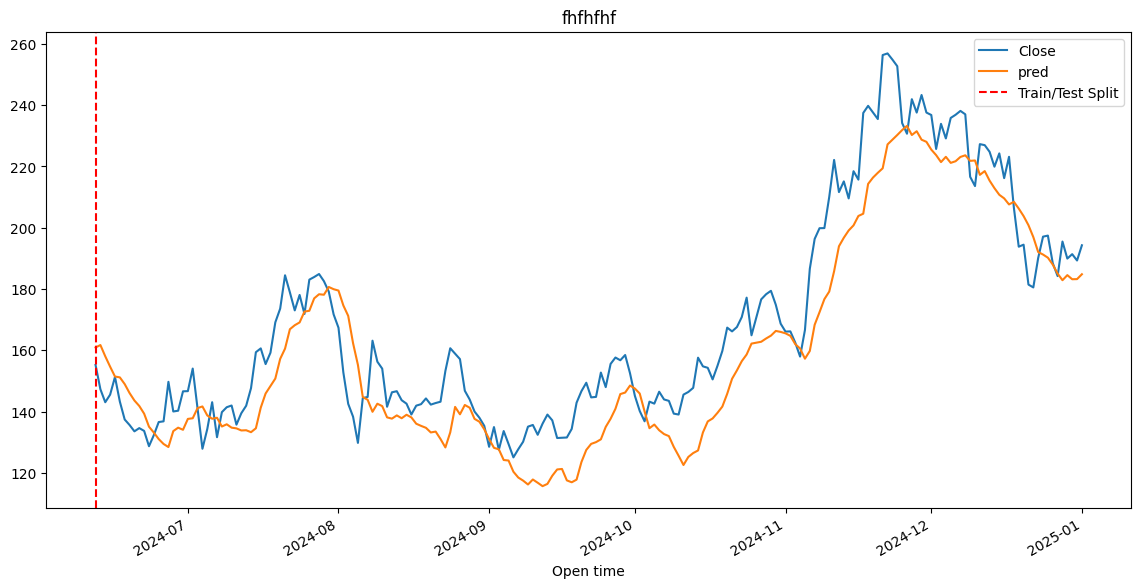

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

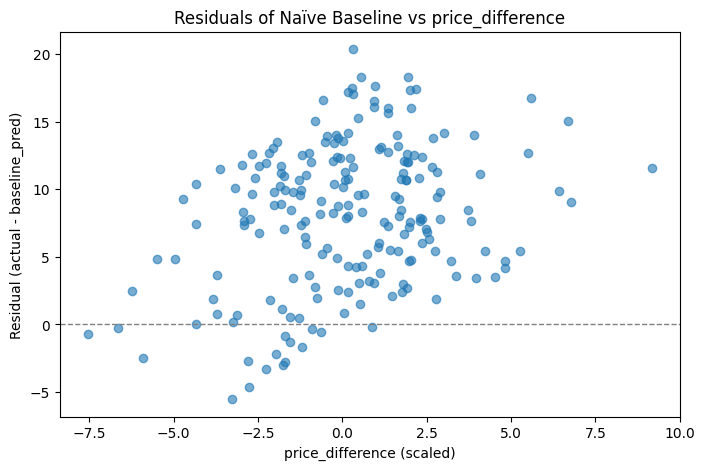

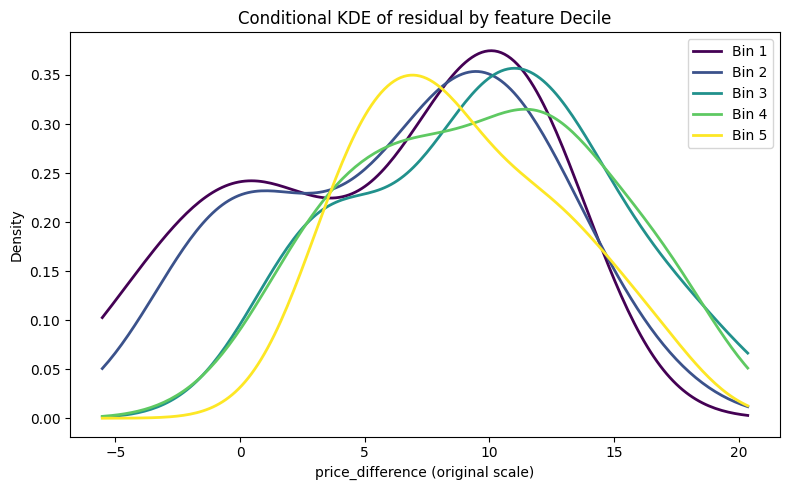

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)